In [1]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm
import bayes3d.genjax
console = genjax.pretty(show_locals=False)
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import Diff
import inspect

ModuleNotFoundError: No module named 'bayes3d.enumerations'

In [ ]:
b.setup_visualizer()

In [ ]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

In [ ]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

In [ ]:
importance_jit = jax.jit(b.genjax.model.importance)
add_object_jit = jax.jit(b.genjax.add_object)

In [ ]:
contact_enumerators = [b.genjax.make_enumerator([f"contact_params_{i}", "variance", "outlier_prob"]) for i in range(5)]

In [2]:
def c2f_contact_update(trace_, key,  number, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
    scores = contact_enumerators[number][3](trace_, key, contact_param_grid, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_enumerators[number][0](
        trace_, key,
        contact_param_grid[i], VARIANCE_GRID[j], OUTLIER_GRID[k]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update, static_argnames=("number",))

NameError: name 'jax' is not defined

In [3]:
VARIANCE_GRID = jnp.array([0.00001, 0.0001, 0.001])
OUTLIER_GRID = jnp.array([0.01, 0.001, 0.0001])
# VARIANCE_GRID = jnp.array([0.001])
# OUTLIER_GRID = jnp.array([ 0.0001])
OUTLIER_VOLUME = 100.0

grid_params = [
    (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi/3, (11,11,11)), (0.05, 0.0, (11,11,1)),
    (0.05, jnp.pi/5, (11,11,11)), (0.02, 2*jnp.pi, (5,5,51))
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]
key = jax.random.PRNGKey(500)

NameError: name 'jnp' is not defined

[21  2  4  6]

    SCORE: -18719.8125000
    VARIANCE: 0.0044108 OUTLIER_PROB 0.0001638
    


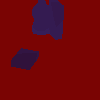

In [32]:
key, (_,gt_trace) = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "parent_3": 0,
    "id_0": jnp.int32(21),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_parent_3": 2,
    "face_child_1": 3,
    "face_child_2": 3,
    "face_child_3": 3,
}), (
    jnp.arange(4),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, OUTLIER_VOLUME)
)
print(b.genjax.get_indices(gt_trace))
b.genjax.print_trace(gt_trace)
b.genjax.viz_trace_meshcat(gt_trace)

choices = gt_trace.get_choices()
key, (_,trace) = importance_jit(key, choices, (jnp.arange(1), jnp.arange(22), *gt_trace.get_args()[2:]))
# b.genjax.viz_trace_meshcat(trace)

b.get_depth_image(gt_trace["image"][...,2])

In [33]:
import joblib

In [35]:
joblib.dump((gt_trace.get_choices(), gt_trace.get_args()), "trace.joblib")

['trace.joblib']

In [38]:
key, (_,reconstructed_trace)= importance_jit(key, *joblib.load("trace.joblib"))

In [39]:
b.genjax.print_trace(reconstructed_trace)


    SCORE: -18719.8125000
    VARIANCE: 0.0044108 OUTLIER_PROB 0.0001638
    


In [10]:
for _ in range(3):
    all_paths = []
    for obj_id in tqdm(range(len(b.RENDERER.meshes)-1)):
        path = []
        trace_ = add_object_jit(trace, key, obj_id, 0, 2,3)
        number = b.genjax.get_contact_params(trace_).shape[0] - 1
        path.append(trace_)
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            trace_ = c2f_contact_update_jit(trace_, key, number,
                contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
            path.append(trace_)
        # for c2f_iter in range(len(contact_param_gridding_schedule)):
        #     trace_ = c2f_contact_update_jit(trace_, key, number,
        #         contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
        all_paths.append(
            path
        )
    
    scores = jnp.array([t[-1].get_score() for t in all_paths])
    print(scores)
    normalized_scores = b.utils.normalize_log_scores(scores)
    t = all_paths[jnp.argmax(scores)][-1]
    b.genjax.viz_trace_meshcat(t)
    trace = t

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.17s/it]


[116836.12  119387.28  116206.59  105204.125 113933.234 103928.64
 108626.11  102906.875 106377.11  101833.14  120242.67  120872.68
  95885.86  106799.04  101741.19  129202.39   97774.47   97960.3
 102446.95  103681.875 102013.07 ]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.32s/it]


[130082.64  129426.836 130073.5   130686.64  130003.97  138502.39
 143199.86  137480.64  131804.66  135508.84  128874.84  130133.95
 126063.97  132604.81  131323.3   130080.69  132348.23  132175.2
 136442.02  134814.38  135684.62 ]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.46s/it]

[143885.34 143229.55 143876.22 143770.62 143806.67 147830.77 143568.95
 148378.64 143751.47 146170.52 142677.58 143936.67 139866.67 143767.52
 141777.47 143883.4  146150.94 145977.9  151968.06 142031.69 144543.33]


In [72]:
b.genjax.viz_trace_meshcat(gt_trace)


In [55]:
b.genjax.get_indices(trace)

Array([21,  1, 13, 18], dtype=int32)

In [27]:
t = all_paths[15][-1]
b.genjax.viz_trace_meshcat(t)
b.genjax.print_trace(t)


    SCORE: 119881.8906250
    VARIANCE: 0.0000100 OUTLIER_PROB 0.0100000
    


In [28]:
t = all_paths[11][-1]
b.genjax.viz_trace_meshcat(t)
b.genjax.print_trace(t)


    SCORE: 120331.1875000
    VARIANCE: 0.0000100 OUTLIER_PROB 0.0100000
    


In [47]:
b.genjax.viz_trace_meshcat(all_paths[15][-1])

In [49]:
scores.argmax()

Array(11, dtype=int32)